In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

In [28]:
import math

In [74]:
df = pd.read_csv('./Temperature data (1).csv', delimiter=',')


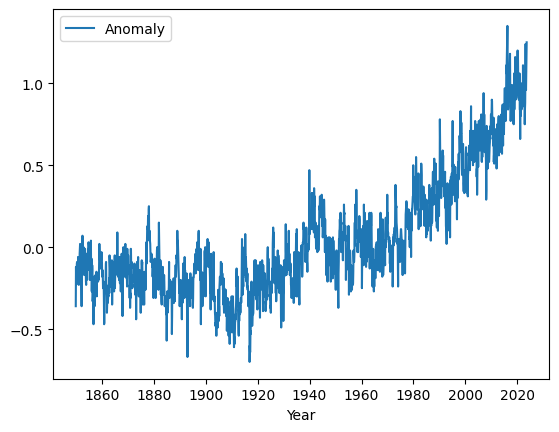

In [75]:
df['Time'] = pd.to_datetime(df['Year'], format='%Y-%m')
df = df.drop(['Year'], axis=1)
index_df = df.set_index('Time')
plt.plot(index_df['Anomaly'])
plt.xlabel('Year')
plt.legend(['Anomaly'])
plt.show()

In [80]:
df_len = len(df)
print(df.head())
training_date_len = math.ceil(df_len * 0.8)
train_data = df.iloc[:training_date_len, :1].values
test_data = df.iloc[training_date_len:, :1].values
print(train_data.shape, test_data.shape)

train_data_index = df.iloc[:training_date_len, 1:2].values
test_data_index = df.iloc[training_date_len:, 1:2].values

print(train_data_index, test_data_index)


   Anomaly       Time
0    -0.36 1850-01-01
1    -0.12 1850-02-01
2    -0.23 1850-03-01
3    -0.19 1850-04-01
4    -0.19 1850-05-01
(1668, 1) (416, 1)
[['1850-01-01T00:00:00.000000000']
 ['1850-02-01T00:00:00.000000000']
 ['1850-03-01T00:00:00.000000000']
 ...
 ['1988-10-01T00:00:00.000000000']
 ['1988-11-01T00:00:00.000000000']
 ['1988-12-01T00:00:00.000000000']] [['1989-01-01T00:00:00.000000000']
 ['1989-02-01T00:00:00.000000000']
 ['1989-03-01T00:00:00.000000000']
 ['1989-04-01T00:00:00.000000000']
 ['1989-05-01T00:00:00.000000000']
 ['1989-06-01T00:00:00.000000000']
 ['1989-07-01T00:00:00.000000000']
 ['1989-08-01T00:00:00.000000000']
 ['1989-09-01T00:00:00.000000000']
 ['1989-10-01T00:00:00.000000000']
 ['1989-11-01T00:00:00.000000000']
 ['1989-12-01T00:00:00.000000000']
 ['1990-01-01T00:00:00.000000000']
 ['1990-02-01T00:00:00.000000000']
 ['1990-03-01T00:00:00.000000000']
 ['1990-04-01T00:00:00.000000000']
 ['1990-05-01T00:00:00.000000000']
 ['1990-06-01T00:00:00.000000000']
 ['

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

print (train_data_normalized.shape, test_data_normalized.shape)

(1668, 1) (416, 1)


In [36]:
X_train = []
y_train = []
interval = 24
for i in range(interval, len(train_data_normalized)):
    X_train.append(train_data_normalized[i-interval:i, 0])
    y_train.append(train_data_normalized[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_test = []
y_test = []
for i in range(interval, len(test_data_normalized)):
    X_test.append(test_data_normalized[i-interval:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)


X_train : (1644, 24, 1) y_train : (1644,)
X_test : (392, 24, 1) y_test : (392,)


In [38]:
regressor = Sequential()

regressor.add(SimpleRNN(units=interval, return_sequences=True, activation= "tanh", input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units=interval, return_sequences=True, activation= "tanh"))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units=interval, return_sequences=True, activation= "tanh"))

regressor.add(Dense(units=1, activation='sigmoid'))
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

Epoch 1/20
822/822 [==============================] - 4s 4ms/step - loss: 0.0263
Epoch 2/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0239
Epoch 3/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0232
Epoch 4/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0234
Epoch 5/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0227
Epoch 6/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0231
Epoch 7/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0233
Epoch 8/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0228
Epoch 9/20
822/822 [==============================] - 3s 3ms/step - loss: 0.0228
Epoch 10/20
822/822 [==============================] - 3s 3ms/step - loss: 0.0225
Epoch 11/20
822/822 [==============================] - 3s 3ms/step - loss: 0.0225
Epoch 12/20
822/822 [==============================] - 3s 4ms/step - loss: 0.0228
Epoch 13/20
822/822 [====

In [64]:
def forecast(model, initial_sequence, n_steps):
    sequence = initial_sequence.copy()
    predictions = []

    for _ in range(n_steps):
        prediction = model.predict(sequence[np.newaxis, :, :])[0,0]
        predictions.append(prediction)

        sequence = np.roll(sequence, -1)
        sequence[-1] = prediction

    return predictions

# Get the initial sequence from the end of the training data
initial_sequence = X_train[-1]

# Forecast the first 12 months of the test data
forecasted_values = forecast(regressor, initial_sequence, 12)


1/1 [==============================] - 0s 9ms/step


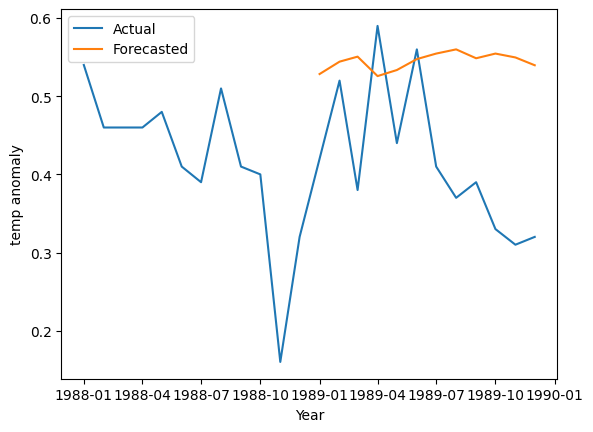

In [85]:
import matplotlib.pyplot as plt

# Get the actual values for the first 12 months of the test data
actual_values_end = y_test[:12]
actual_values_start = y_train[len(y_train)-12:]
actual_values = np.concatenate((actual_values_start, actual_values_end), axis=0)

actual_values_index_end = test_data_index[:12]
actual_values_index = np.concatenate((train_data_index[len(train_data_index)-12:], test_data_index[:12]), axis=0)

# Reshape the actual values to 2D
actual_values = actual_values.reshape(-1, 1)

# Inverse transform the actual values to get them in the original scale
actual_values = scaler.inverse_transform(actual_values)

# Plot the actual values
plt.plot(actual_values_index, actual_values, label='Actual')

# Plot the forecasted values
plt.plot(actual_values_index_end, forecasted_values, label='Forecasted')
plt.xlabel('Year')
plt.ylabel('temp anomaly')

# Add a legend
plt.legend()

# Show the plot
plt.show()